In [1]:
# Transformers installation
! pip install transformers
! pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
data_frame = pd.read_csv('/content/train.csv')

In [4]:
data_frame.head()

,text,label
0,− Scope 3: Optional scope that includes indire...,1
1,The Group is not aware of any noise pollution ...,0
2,Global climate change could exacerbate certain...,0
3,Setting an investment horizon is part and parc...,0
4,Climate change the physical impacts of climate...,0


Read the dataset

In [5]:
def batch_encode(tokenizer, texts, batch_size=256, max_length=90):
    """""""""
    A function that encodes a batch of texts and returns the texts'
    corresponding encodings and attention masks that are ready to be fed
    into a pre-trained transformer model.

    Input:
        - tokenizer:   Tokenizer object from the PreTrainedTokenizer Class
        - texts:       List of strings where each string represents a text
        - batch_size:  Integer controlling number of texts in a batch
        - max_length:  Integer controlling max number of words to tokenize in a given text
    Output:
        - input_ids:       sequence of texts encoded as a tf.Tensor object
        - attention_mask:  the texts' attention mask encoded as a tf.Tensor object
    """""""""

    input_ids = []
    attention_mask = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_length,
                                             padding='longest', #implements dynamic padding
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=False
                                             )
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])


    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)

In [6]:
from pathlib import Path
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast
import numpy as np
from tensorflow.keras.utils import to_categorical

# Preprocess data
X = list(data_frame["text"])
y1 = list(data_frame["label"])
y = to_categorical(y1, 3)
"""
y = np.zeros((len(X),2))
for index in range(0,len(y)):
  y[index,data_frame["Label"].iloc[index]] = 1
"""

# train_texts, val_texts, train_labels, val_labels = train_test_split(X, y, test_size=0.2)
# train_model_X, test_texts, train_model_y, test_labels = train_test_split(X, y, test_size=0.2)
train_texts, val_texts, train_labels, val_labels = train_test_split(X, y, test_size=0.2)


In [7]:
import tensorflow as tf
# Instantiate DistilBERT tokenizer...we use the Fast version to optimize runtime
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Encode X_train
X_train_ids, X_train_attention = batch_encode(tokenizer, train_texts)

# Encode X_valid
X_valid_ids, X_valid_attention = batch_encode(tokenizer, val_texts)

# Encode X_test
#X_test_ids, X_test_attention = batch_encode(tokenizer, test_texts)

In [8]:
index = 90
train_texts[index]

'Climate change is increasing the frequency and intensity of natural disasters. According to a report by the United Nations Office for Disaster Risk Reduction (UNDRR), there were 7,255 natural disasters worldwide within the 20 years from 1998 to 2017, and 91% of them were climate-related. Moreover, among disasters associated with climate change, such as floods, storms, drought and heat waves, damage from floods and storms is particularly heavy, and the number of such disasters increased 2.2 times compared with the previous 20 years.'

In [9]:
X_train_ids[index]

<tf.Tensor: shape=(90,), dtype=int32, numpy=
array([  101,  4785,  2689,  2003,  4852,  1996,  6075,  1998,  8015,
        1997,  3019, 18665,  1012,  2429,  2000,  1037,  3189,  2011,
        1996,  2142,  3741,  2436,  2005,  7071,  3891,  7312,  1006,
        6151, 12171,  1007,  1010,  2045,  2020,  1021,  1010, 20637,
        3019, 18665,  4969,  2306,  1996,  2322,  2086,  2013,  2687,
        2000,  2418,  1010,  1998,  6205,  1003,  1997,  2068,  2020,
        4785,  1011,  3141,  1012,  9308,  1010,  2426, 18665,  3378,
        2007,  4785,  2689,  1010,  2107,  2004, 14295,  1010, 12642,
        1010, 14734,  1998,  3684,  5975,  1010,  4053,  2013, 14295,
        1998, 12642,  2003,  3391,  3082,  1010,  1998,  1996,   102],
      dtype=int32)>

In [10]:
def build_model(transformer, base_learning_rate, max_length=90):
    """
    Template for building a model off of the BERT or DistilBERT architecture
    for a binary classification task.

    Input:
      - transformer:  a base Hugging Face transformer model object (BERT or DistilBERT)
                      with no added classification head attached.
      - max_length:   integer controlling the maximum number of encoded tokens
                      in a given sequence.

    Output:
      - model:        a compiled tf.keras.Model with added classification layers
                      on top of the base pre-trained model architecture.
    """
    params = {'LAYER_DROPOUT': 0.2,
              'RANDOM_STATE': 100}

    # Define weight initializer with a random seed to ensure reproducibility
    weight_initializer = tf.keras.initializers.GlorotNormal(seed=100)

    # Define input layers
    input_ids_layer = tf.keras.layers.Input(shape=(max_length,),
                                            name='input_ids',
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,),
                                                  name='input_attention',
                                                  dtype='int32')
      # DistilBERT outputs a tuple where the first element at index 0
    # represents the hidden-state at the output of the model's last layer.
    # It is a tf.Tensor of shape (batch_size, sequence_length, hidden_size=768).
    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]

    # We only care about DistilBERT's output for the [CLS] token, which is located
    # at index 0.  Splicing out the [CLS] tokens gives us 2D data.
    cls_token = last_hidden_state[:, 0, :]

    D1 = tf.keras.layers.Dropout(params['LAYER_DROPOUT'],
                                 seed=params['RANDOM_STATE']
                                )(cls_token)

    X = tf.keras.layers.Dense(256,
                              activation='relu',
                              kernel_initializer=weight_initializer,
                              bias_initializer='zeros'
                              )(D1)

    D2 = tf.keras.layers.Dropout(params['LAYER_DROPOUT'],
                                 seed=params['RANDOM_STATE']
                                )(X)
    X = tf.keras.layers.Dense(32,
                              activation='relu',
                              kernel_initializer=weight_initializer,
                              bias_initializer='zeros'
                              )(D2)

    D3 = tf.keras.layers.Dropout(params['LAYER_DROPOUT'],
                                 seed=params['RANDOM_STATE']
                                )(X)

    # Define a single node that makes up the output layer (for binary classification)
    output = tf.keras.layers.Dense(3,
                                   activation='softmax',
                                   kernel_initializer=weight_initializer,  # CONSIDER USING CONSTRAINT
                                   bias_initializer='zeros'
                                   )(D3)

    # Define the model
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)

    # Compile the model
    model.compile(tf.keras.optimizers.Adam(lr=base_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [11]:
# The bare, pretrained DistilBERT transformer model outputting raw hidden-states
# and without any specific head on top.
from transformers import TFDistilBertModel, DistilBertConfig
config = DistilBertConfig(dropout=0.2,
                          attention_dropout=0.2,
                          output_hidden_states=True)
distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

# Freeze DistilBERT layers to preserve pre-trained weights
for layer in distilBERT.layers:
    layer.trainable = False

# Build model
base_learning_rate = 0.0001
model = build_model(distilBERT, base_learning_rate)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 90)]         0           []                               
                                                                                                  
 input_attention (InputLayer)   [(None, 90)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'input_attention[0][0]']        
                                one, 90, 768),                                                    
                                 hidden_states=((No                                           

In [12]:
# Train the model
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

epochs_value = 100
train_history1 = model.fit(
    x = [X_train_ids, X_train_attention],
    y = train_labels,
    epochs = epochs_value,
    batch_size = 16,
    validation_data = ([X_valid_ids, X_valid_attention], val_labels),
    verbose=1
)

Epoch 1/100
50/50 [==============================] - 11s 100ms/step - loss: 0.8986 - accuracy: 0.5337 - val_loss: 0.6662 - val_accuracy: 0.7350
Epoch 2/100
50/50 [==============================] - 3s 68ms/step - loss: 0.7329 - accuracy: 0.6775 - val_loss: 0.6623 - val_accuracy: 0.6950
Epoch 3/100
50/50 [==============================] - 3s 65ms/step - loss: 0.6611 - accuracy: 0.7025 - val_loss: 0.5426 - val_accuracy: 0.7750
Epoch 4/100
50/50 [==============================] - 3s 65ms/step - loss: 0.6110 - accuracy: 0.7200 - val_loss: 0.5219 - val_accuracy: 0.8050
Epoch 5/100
50/50 [==============================] - 3s 66ms/step - loss: 0.5897 - accuracy: 0.7638 - val_loss: 0.6719 - val_accuracy: 0.7200
Epoch 6/100
50/50 [==============================] - 4s 86ms/step - loss: 0.6028 - accuracy: 0.7425 - val_loss: 0.5549 - val_accuracy: 0.7800
Epoch 7/100
50/50 [==============================] - 4s 81ms/step - loss: 0.5632 - accuracy: 0.7713 - val_loss: 0.5262 - val_accuracy: 0.7950
Epoc

In [13]:
# Encode X_train
input_ids = []
attention_mask = []
inputs = tokenizer("Conspiracy", return_tensors="tf")
input_ids.extend(inputs['input_ids'])
attention_mask.extend(inputs['attention_mask'])
outputs = model.predict([input_ids, attention_mask])
print(outputs)

1/1 [==============================] - 2s 2s/step
[[1.3355349e-01 8.6577445e-01 6.7208940e-04]]


In [17]:
test_data = pd.read_csv('test.csv')
test_data.head()

,text,label
0,Sustainable strategy ‘red lines’ For our susta...,0
1,"Verizon’s environmental, health and safety man...",1
2,"In 2019, the Company closed a series of transa...",1
3,"In December 2020, the AUC approved the Electri...",0
4,"Finally, there is a reputational risk linked t...",0


In [20]:
import numpy as np

test_text = test_data['text'].to_list()
test_labels_set = np.array(test_data['label'].to_list())

#tokenize texts
X_test_ids, X_test_attention = batch_encode(tokenizer, test_text)

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Generate predictions
y_pred = model.predict([X_test_ids, X_test_attention])

#y_pred_thresh = np.where(y_pred >= 0.5, 1, 0)
y_pred_thresh = np.argmax(y_pred, axis = 1)

#test_labels_set = np.argmax(test_labels, axis = 1)
# Get evaluation results
accuracy = accuracy_score(test_labels_set, y_pred_thresh)

print('Accuracy:  ', accuracy)

10/10 [==============================] - 2s 91ms/step
Accuracy:   0.76875


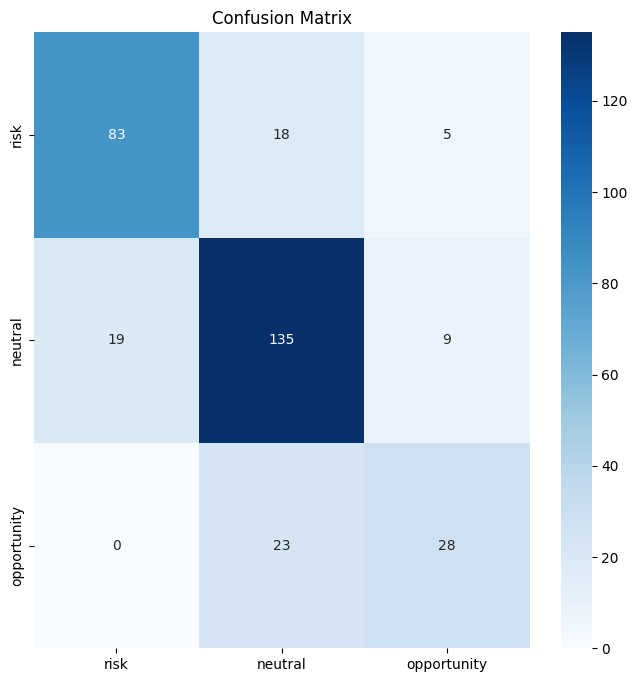

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

main_labels = ['risk', 'neutral', 'opportunity']

plt.figure(figsize = (8,8))
sns.heatmap(confusion_matrix(test_labels_set, y_pred_thresh), annot = True, fmt = 'g', cmap = "Blues", xticklabels = main_labels, yticklabels = main_labels)
plt.title("Confusion Matrix")
plt.show()

### Corrected: Saving and loading the model

In [24]:
# Save the model
model.save("final_model.h5")#you can use any prefer name for the model name

In [25]:
# Load the model with a different name
# hace to sepcify any custom objects which are not coming up with kers object scope
# otherwise the model will not load
final_model = tf.keras.models.load_model('final_model.h5', custom_objects={'TFDistilBertModel': TFDistilBertModel})

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Generate predictions
y_pred = final_model.predict([X_test_ids, X_test_attention])

#y_pred_thresh = np.where(y_pred >= 0.5, 1, 0)
y_pred_thresh = np.argmax(y_pred, axis = 1)

#test_labels_set = np.argmax(test_labels, axis = 1)
# Get evaluation results
accuracy = accuracy_score(test_labels_set, y_pred_thresh)

print('Accuracy:  ', accuracy)

10/10 [==============================] - 2s 109ms/step
Accuracy:   0.76875
